In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [0]:
cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
!pwd

/content/drive/My Drive


In [0]:
!ls

autoencoder8.h5		    phaseTwo_generateEmbeddings.ipynb
embeddings_all_list.npy     phaseTwo_ImageNet.ipynb
embeddings_one_arr.npy	    phaseTwo_ImageNet_mobile_5_trainworks.ipynb
hdf5			    phaseTwo_ImageNet_mobile_6final.ipynb
phaseOne_Autoencoder.ipynb


In [0]:
!pip install -q keras

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9874095803963583966, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12819425617174300046
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15948810693220745316
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14620680619352594936
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# **ImageNet**

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
import numpy as np
import pandas as pd


from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Conv3D, Conv3DTranspose, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Input, BatchNormalization, Dropout, Lambda, Bidirectional
from keras.layers import CuDNNLSTM, Reshape, PReLU, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model
from keras.callbacks import Callback
from keras.utils import plot_model

from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import time 
import tensorflow as tf
from sklearn import metrics
import pickle
import os
import scipy.io as sio

import keras
import sklearn

Using TensorFlow backend.


In [0]:
import PIL

In [0]:
#from google.colab import files
#files.download("embeddings.npy")

In [0]:

np.random.seed(5)
tf.set_random_seed(5)

In [0]:

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [0]:
import h5py

In [0]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [0]:
len(os.listdir("/content/drive/My Drive/hdf5"))

101

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, filepath, list_batches, embeddings, batch_size=1, shuffle=True):
        'Initialization'
        self.filepath = filepath
        self.list_batches = list_batches
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.embeddings = embeddings # embeddings in order batch_0.h5, batch_1.h5, ...
        self.on_epoch_end()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_batches)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_batches_temp = [self.list_batches[k] for k in indexes]
        
        # Generate data
        images, embeddings = self.__data_generation(list_batches_temp, indexes, self.embeddings)

        return images, embeddings

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_batches))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __data_generation(self, list_batches_temp, indexes, embeddings):
        'Generates data containing batch_size samples' 
        # Initialization
        with h5py.File(self.filepath+"/"+list_batches_temp[0]) as f:
            images = np.swapaxes(f['data'].value, 1, 3)

        max_min_mean = ( images.max() + images.min() ) / 2
        images = (images - max_min_mean) / (images.max() - max_min_mean)  # scaling to range  -1 to 1

        embeddings_copy = embeddings.copy()
        embedding_batch = embeddings_copy[self.list_batches.index(list_batches_temp[0])]

        images, embedding_batch = sklearn.utils.shuffle(images, embedding_batch) # shuffle within the batch itself
        
        return images[:, 1:225, 1:225, :], embedding_batch

In [0]:
embeddings = np.load("embeddings_all_list.npy")

In [0]:
listdir = os.listdir("/content/drive/My Drive/hdf5")

import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
  
listdir_sorted = sorted_aphanumeric(listdir)
listdir_sorted

['batch_0.h5',
 'batch_1.h5',
 'batch_2.h5',
 'batch_3.h5',
 'batch_4.h5',
 'batch_5.h5',
 'batch_6.h5',
 'batch_7.h5',
 'batch_8.h5',
 'batch_9.h5',
 'batch_10.h5',
 'batch_11.h5',
 'batch_12.h5',
 'batch_13.h5',
 'batch_14.h5',
 'batch_15.h5',
 'batch_16.h5',
 'batch_17.h5',
 'batch_18.h5',
 'batch_19.h5',
 'batch_20.h5',
 'batch_21.h5',
 'batch_22.h5',
 'batch_23.h5',
 'batch_24.h5',
 'batch_25.h5',
 'batch_26.h5',
 'batch_27.h5',
 'batch_28.h5',
 'batch_29.h5',
 'batch_30.h5',
 'batch_31.h5',
 'batch_32.h5',
 'batch_33.h5',
 'batch_34.h5',
 'batch_35.h5',
 'batch_36.h5',
 'batch_37.h5',
 'batch_38.h5',
 'batch_39.h5',
 'batch_40.h5',
 'batch_41.h5',
 'batch_42.h5',
 'batch_43.h5',
 'batch_44.h5',
 'batch_45.h5',
 'batch_46.h5',
 'batch_47.h5',
 'batch_48.h5',
 'batch_49.h5',
 'batch_50.h5',
 'batch_51.h5',
 'batch_52.h5',
 'batch_53.h5',
 'batch_54.h5',
 'batch_55.h5',
 'batch_56.h5',
 'batch_57.h5',
 'batch_58.h5',
 'batch_59.h5',
 'batch_60.h5',
 'batch_61.h5',
 'batch_62.h5',
 '

In [0]:
training_generator = DataGenerator(filepath = "/content/drive/My Drive/hdf5",  list_batches = listdir_sorted, embeddings = embeddings)

In [0]:
#def generate_batches_phaseTwo(filepath, embeddings_array, batch_size):
#  while True:
#    i = 0
#    k = 0
#    for batch_file in os.listdir(filepath):
#      
#      f = h5py.File(filepath+"/"+batch_file)
#      images = f['data'].value
#      images = np.swapaxes(images, 1, 3) # swap axis, channel should be last
#      
#      img_number = images.shape[0]
#      i_final = img_number // batch_size
#      
#      #voxels = f['label-voxel'].value
#      #voxels = np.swapaxes(voxels, 1, 4)
#      
#      if i == i_final:
#        break
#      else:
#        images = images[16*i:16*(i+1), 1:225, 1:225, :] # slice images, imagenet takes (224, 224, 3), provided (227, 227, 3) 
#        embeddings = embeddings_array[k][16*i:16*(i+1)]
#      
#      i += 1
#      yield (images, embeddings)
#     
#    k += 1
    

In [0]:
#predicted_embeddings = np.load("embeddings_one_arr.npy")
#predicted_embeddings.shape

(20056, 64)

In [0]:
## učitavanje svih slika u RAM, crasha... 25 batcha uspije loadati, onda ispuni svu memoriju
#
#f = h5py.File("/content/drive/My Drive/hdf5"+"/"+listdir_sorted[0])
#images = np.swapaxes(f['data'].value, 1, 3)[:,1:225,1:225, :]
#print(listdir_sorted[0])
#
#def load_all_images(listdir_sorted, images):
#  i = 0
#  # učitavanje svih slika!
#  for batch_file in listdir_sorted[1:]:
#    print(batch_file)
#    images = np.vstack((images, np.swapaxes(h5py.File("/content/drive/My Drive/hdf5"+"/"+batch_file)['data'].value, 1, 3)[:,1:225,1:225, :]))
#    
#load_all_images(listdir_sorted, images)

batch_0.h5
batch_1.h5
batch_2.h5
batch_3.h5
batch_4.h5
batch_5.h5
batch_6.h5
batch_7.h5
batch_8.h5
batch_9.h5
batch_10.h5
batch_11.h5
batch_12.h5
batch_13.h5
batch_14.h5
batch_15.h5
batch_16.h5
batch_17.h5
batch_18.h5
batch_19.h5
batch_20.h5
batch_21.h5
batch_22.h5
batch_23.h5
batch_24.h5


In [0]:

#images_all = load_all_images(listdir_sorted)

In [0]:
with open('embeddings.pickle', 'wb') as handle:
    pickle.dump(predicted_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
!ls

autoencoder8.h5		 phaseOne_Autoencoder.ipynb
embeddings_all_list.npy  phaseTwo_generateEmbeddings.ipynb
embeddings_list.npy	 phaseTwo_ImageNet.ipynb
embeddings.npy		 phaseTwo_ImageNet_mobile.ipynb
embeddings_one_arr.npy	 Untitled0.ipynb
hdf5


In [0]:
 # loss func
def euclidean_distance_loss(y_true, y_pred): 
    """ Euclidean distance loss https://en.wikipedia.org/wiki/Euclidean_distance 
    :param y_true: TensorFlow/Theano tensor 
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true :return: float """ 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [0]:
def mobile_net():
    mobilenetv2 = MobileNetV2(include_top = False, input_shape = (224,224,3))

    flat = Flatten(name = "flat")(mobilenetv2.output)
    x = Dense(64, name = "dense_out")(flat)
    mobilenetv2_regress = Model(inputs = mobilenetv2.input, outputs = x)
    #mobilenetv2_regress.summary()

    # leave only last 2 block trainable
    for layer in mobilenetv2_regress.layers[:-22]:
        layer.trainable = False

    return mobilenetv2_regress

In [0]:
x = mobile_net()

In [0]:
# load pretrained model
x = load_model("mobile_regress_5.h5", custom_objects = {"euclidean_distance_loss": euclidean_distance_loss})

In [0]:
x.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
x.compile(optimizer='adam', loss=euclidean_distance_loss, metrics = ["mae"])

In [0]:
!nvidia-smi

Thu Jan 24 20:59:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    76W / 149W |   8393MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
history = x.fit_generator(generator = training_generator, verbose = 1, epochs = 20, use_multiprocessing=True )

Epoch 1/20
101/101 [==============================] - 438s 4s/step - loss: 11.2565 - mean_absolute_error: 1.1327
Epoch 2/20
101/101 [==============================] - 318s 3s/step - loss: 11.1209 - mean_absolute_error: 1.1193
Epoch 3/20
101/101 [==============================] - 318s 3s/step - loss: 10.8379 - mean_absolute_error: 1.0905
Epoch 4/20
101/101 [==============================] - 319s 3s/step - loss: 11.1835 - mean_absolute_error: 1.1258
Epoch 5/20
101/101 [==============================] - 320s 3s/step - loss: 10.8121 - mean_absolute_error: 1.0888
Epoch 6/20
101/101 [==============================] - 319s 3s/step - loss: 10.7830 - mean_absolute_error: 1.0861
Epoch 7/20
101/101 [==============================] - 317s 3s/step - loss: 10.7256 - mean_absolute_error: 1.0815
Epoch 8/20
101/101 [==============================] - 316s 3s/step - loss: 10.4811 - mean_absolute_error: 1.0557
Epoch 9/20
101/101 [==============================] - 315s 3s/step - loss: 9.9916 - mean_absolut

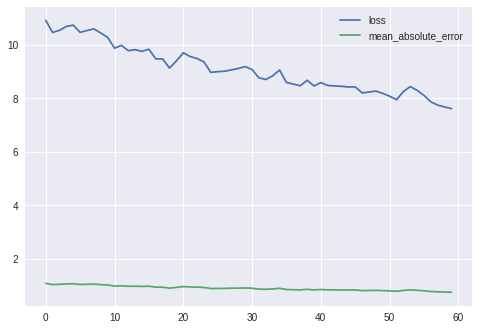

In [0]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["mean_absolute_error"], label = "mean_absolute_error")

plt.legend()

In [0]:
x.save("mobile_regress_6.h5")

In [0]:
!ls

autoencoder8.h5		 mobile_regress_5.h5
embeddings_all_list.npy  phaseOne_Autoencoder.ipynb
embeddings_one_arr.npy	 phaseTwo_generateEmbeddings.ipynb
hdf5			 phaseTwo_ImageNet.ipynb
mobile_regress3.h5	 phaseTwo_ImageNet_mobile_5_trainworks.ipynb
mobile_regress_4.h5	 phaseTwo_ImageNet_mobile_6final.ipynb


In [0]:
from google.colab import files
files.download("mobile_regress_4.h5")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 45176, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
!kill

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [0]:
!kill -9 -1